# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import numpy as np
import torch

import sys
import os

sys.path.append(os.path.abspath('python/'))

from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
env = UnityEnvironment(seed=seed, file_name="Tennis_Windows_x86_64/Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Train the Agent

In [6]:
# MADDPG 
from maddpg_agent import maddpg_agent

maddpg = maddpg_agent() 

In [7]:
## Saves model weights to file
def save_weights(dir):
    for i in range(num_agents):
        torch.save(maddpg.agents[i].actor_local.state_dict(),                     
              os.path.join(dir, 'checkpoint_actor_{}.pth'.format(i)) )
        torch.save(maddpg.agents[i].critic_local.state_dict(), 
              os.path.join(dir, 'checkpoint_critic_{}.pth'.format(i)) )

In [8]:
from collections import deque
import time

def train(maddpg, env, dir_chkpoints, n_episodes=1000, save_every=50):
    """Training loop helper for running the environment using the MADDPG algorithm.
    Params
    ======
        maddpg: instance of maddpg_agent wrapper class
        env (UnityEnvironment): instance of Unity environment for training
        dir_chkpoints: directory to save model weights
        n_episodes (int): number of episodes to train for
        save_every (int): frequency to save model weights
    """
    
    solved = False
    scores_total = []
    scores_deque = deque(maxlen=100)
    scores_global = []
    best_score = 0.0
    time_start = time.time()
    
    # Environment information
    brain_name = env.brain_names[0]

    # Used for learning period to update the model weights
    global_step_number = 0
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
                    
        scores = np.zeros(num_agents)
        maddpg.reset()

        while True:
            actions = maddpg.act(states)

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            global_step_number += 1
            maddpg.step(states, actions, rewards, next_states, dones, global_step_number)

            scores += rewards
            states = next_states

            if np.any(dones):
                break
        
        mean_score = np.mean(scores) # mean on 2 agents
        scores_total.append(mean_score)
        scores_deque.append(mean_score) # mean on 2 agents for 100 episodes
        score_average_100epis = np.mean(scores_deque) # value = mean on 100 episodes 
        scores_global.append(score_average_100epis) # 
        
        print_every = 20
        if i_episode % print_every == 0:
            s = (int)(time.time() - time_start)
            print('Episode: {}, Score: {:.4f}, \tAverage Score: {:.4f}, Time: {:02}:{:02}:{:02} '\
                 .format(i_episode, mean_score,  score_average_100epis, s//3600, s%3600//60, s%60))

        if score_average_100epis >= 0.5 and not solved:
            print('\n*** Environment solved in {:d} episodes!\tAverage Score: {:.2f} ***\n'.format(
                i_episode, score_average_100epis))
            solved = True
            save_weights(dir_chkpoints)
            best_score = score_average_100epis

        if i_episode % save_every == 0 and solved:
            # Only save these weights if they are better than the ones previously saved
            if score_average_100epis > best_score:
                best_score = score_average_100epis
                save_weights(dir_chkpoints)
                s = (int)(time.time() - time_start) 
                print('*** Episode {}\tAverage Score: {:.2f}, Time: {:02}:{:02}:{:02} ***\n '\
                     .format(i_episode, np.mean(scores_deque), s//3600, s%3600//60, s%60))  
        

    return scores_total, scores_global

dir_chkpoints = 'dir_chk_1700d_episodes'
scores_total, scores_global = train(maddpg, env, dir_chkpoints, n_episodes=1700)

Episode: 20, Score: -0.0050, 	Average Score: -0.0050, Time: 00:00:00 
Episode: 40, Score: -0.0050, 	Average Score: -0.0050, Time: 00:00:02 
Episode: 60, Score: -0.0050, 	Average Score: -0.0050, Time: 00:00:07 
Episode: 80, Score: -0.0050, 	Average Score: -0.0050, Time: 00:00:12 
Episode: 100, Score: -0.0050, 	Average Score: -0.0050, Time: 00:00:18 
Episode: 120, Score: -0.0050, 	Average Score: -0.0040, Time: 00:00:23 
Episode: 140, Score: -0.0050, 	Average Score: -0.0025, Time: 00:00:30 
Episode: 160, Score: -0.0050, 	Average Score: -0.0020, Time: 00:00:36 
Episode: 180, Score: -0.0050, 	Average Score: -0.0015, Time: 00:00:43 
Episode: 200, Score: 0.0450, 	Average Score: 0.0040, Time: 00:00:53 
Episode: 220, Score: -0.0050, 	Average Score: 0.0070, Time: 00:01:03 
Episode: 240, Score: 0.0450, 	Average Score: 0.0065, Time: 00:01:09 
Episode: 260, Score: -0.0050, 	Average Score: 0.0085, Time: 00:01:17 
Episode: 280, Score: -0.0050, 	Average Score: 0.0080, Time: 00:01:22 
Episode: 300, Sco

### 5. Plot the  training results 

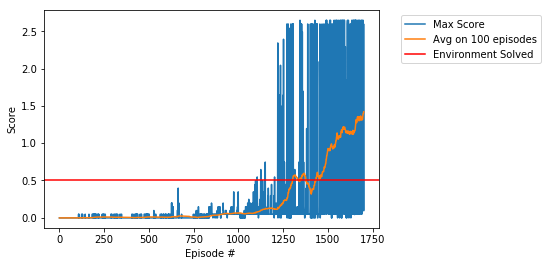

len of scores_total:  1700 
len of score_global:  1700


In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores_total) + 1), scores_total, label="Max Score")
plt.plot(np.arange(1, len(scores_global) + 1), 
    scores_global, label="Avg on 100 episodes") 
# This line indicates the score at which the environment is considered solved
plt.axhline(y=0.5, color="r",  label="Environment Solved") 

plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel("Score")
plt.xlabel("Episode # ")
plt.show()

print('len of scores_total: ', len(scores_total), '\nlen of score_global: ',\
    len(scores_global))

In [10]:
env.close()